We will have the hands on expereince with the neural network classification pronlem .
In order to illustrate  this , first of all lets get our data ready .


In [1]:
from sklearn.datasets import make_circles
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")


First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


**Lets organize the generated circles in the data frame**

In [2]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


under these noise , we want to see how many types of each color circle are being genrated here

In [3]:
circles.label.value_counts()


,count
label,
1,500
0,500


Intrstingly m exactly same  means both have fair shares of value .
Then lets plot this and visualize what we have got till now

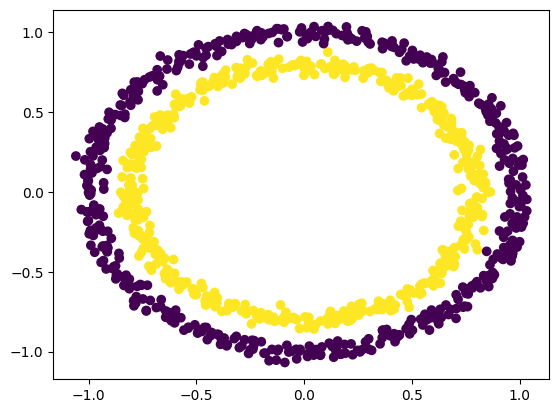

In [4]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.viridis);


Data Shape

In [5]:
X.shape, y.shape


((1000, 2), (1000,))

In [6]:
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")


Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


Its clear that  we are equiped with the data , now lets turn these sorts of data onto torch tensors and split them between test data and training data .

In [7]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]


(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

i encountered error in above steps , because i tried to run this code again .
this was solved while i happened to restart the sessions and run all at once.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)


(800, 200, 800, 200)

**Building a Model**

first of all lets set uo the device agnostic code

In [9]:

from torch import nn
# Detect if GPU is available for faster training. Otherwise use CPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

Lets construct the model

In [10]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)  # first layer
        self.layer_2 = nn.Linear(in_features=5, out_features=1)  # second layer

    def forward(self, x):
        return self.layer_2(self.layer_1(x))


the above code is self-explantory , Lets fit this model into device

In [11]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

Lets define the losss function and optimizer then

In [12]:
loss_fn = nn.BCEWithLogitsLoss()  # Good for binary classification
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)


**Trainig the model**

Lets train our model with the data , feed through loss and optimizer

In [13]:
# Suppose X_train is your input data and y_train the labels
# This will make y_train shape (800, 1) instead of (800,)
y_train = y_train.unsqueeze(1)
epochs = 100
for epoch in range(epochs):
    model_0.train()  # 1. Set model to training mode
    y_pred = model_0(X_train)  # 2. Make predictions
    loss = loss_fn(y_pred, y_train)  # 3. Calculate loss
    optimizer.zero_grad()  # 4. Reset any previous gradients
    loss.backward()  # 5. Backpropagation: compute gradients
    optimizer.step()  # 6. Update model using optimizer
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss: {loss.item():.4f}")


Epoch 0: Loss: 0.7059
Epoch 10: Loss: 0.6969
Epoch 20: Loss: 0.6944
Epoch 30: Loss: 0.6937
Epoch 40: Loss: 0.6935
Epoch 50: Loss: 0.6934
Epoch 60: Loss: 0.6933
Epoch 70: Loss: 0.6933
Epoch 80: Loss: 0.6933
Epoch 90: Loss: 0.6932


No significant decrease in losss is observed . can we increase it upto 1000.
Slight less is observed may be because we are using sgd . Using sgd is like making daily practise to improve the condition.

Any way we have to move to the evaluation phases .

In [14]:
model_0.eval()                   # 1. Set model to evaluation mode
y_test = y_test.unsqueeze(1)

with torch.no_grad():            # 2. Avoid tracking gradients
    test_pred = model_0(X_test)  # 3. Make predictions
    test_loss = loss_fn(test_pred, y_test)  # 4. Calculate loss

lets calculate the accuracy then

In [15]:
# For binary classification
pred_labels = test_pred.round()           # Turn probabilities into 0 or 1
accuracy = (pred_labels == y_test).float().mean()
print(f"Test Accuracy: {accuracy.item():.2%}")


Test Accuracy: 50.00%


Not satisfactory , just random guessing or something else ...
lets predict and plot the  graph

helper_functions.py already exists, skipping download


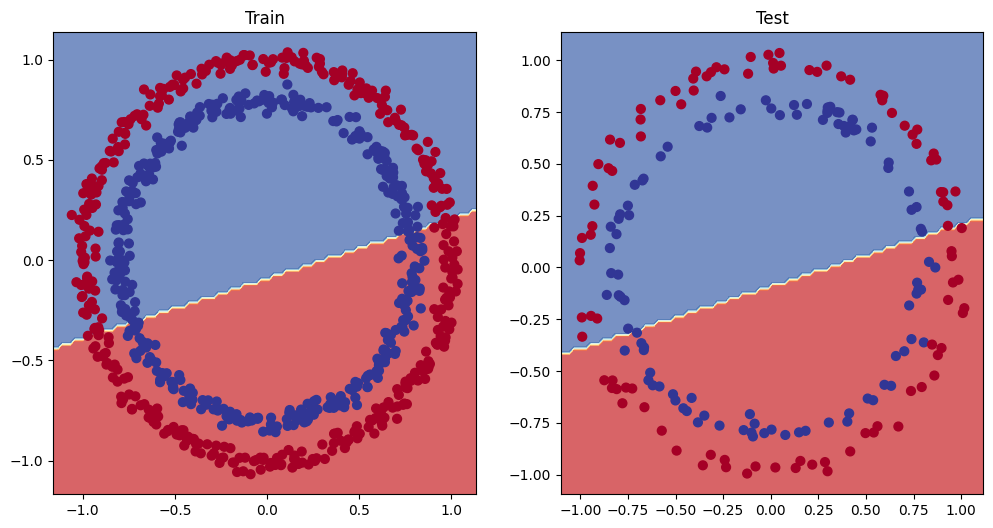

In [17]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


The model's poor performance and 50% accuracy are due to underfitting. It's attempting to separate circular data with a straight line, which is inherently ineffective. This means the model isn't adequately learning the underlying patterns in the data.